In [1]:
from keras.layers import Input, Dense, Lambda, Flatten, Activation, Merge, Concatenate, Add
from keras import layers
from keras.layers.merge import concatenate
from keras.models import Model, Sequential
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler

import numpy as np
from scipy.stats import sem

from keras import backend as K
from keras.models import load_model
import tensorflow as tf

from models import vgg
from models.cvae import CVAE
from utils.angles import deg2bit, bit2deg
from utils.losses import mad_loss_tf, cosine_loss_tf, von_mises_loss_tf, maad_from_deg
from utils.losses import gaussian_kl_divergence_tf, gaussian_kl_divergence_np
from utils.losses  import von_mises_log_likelihood_tf, von_mises_log_likelihood_np
from utils.towncentre import load_towncentre
from utils.experiements import get_experiment_id

Using TensorFlow backend.


In [2]:
xtr, ytr_deg, xval, yval_deg, xte, yte_deg = load_towncentre('data/TownCentre.pkl.gz', canonical_split=True, verbose=1)

image_height, image_width = xtr.shape[1], xtr.shape[2]
ytr_bit = deg2bit(ytr_deg)
yval_bit = deg2bit(yval_deg)
yte_bit = deg2bit(yte_deg)
yte_rad = np.deg2rad(yte_deg)

image_height, image_width, n_channels = xtr.shape[1:]
flatten_x_shape = xtr[0].flatten().shape[0]
phi_shape = yte_bit.shape[1]

Number of train samples: 6916
Number of validation samples: 874
Number of test samples: 904


#### Loading pre-trained models

#### Biternion-VGG (Log-likelihood, fixed $\kappa=3$)

In [3]:
vgg_fixed_kappa = vgg.BiternionVGG(image_height=image_height,
                                   image_width=image_width,
                                   n_channels=3,
                                   predict_kappa=False,
                                   fixed_kappa_value=3.0)

vgg_fixed_kappa.model.load_weights('/Users/sergey/BiternionNet/logs/best_models/von_mises/vgg_bit_von_mises_town.best.weights.h5')

In [4]:
results_fixed = dict()
results_fixed['train'] = vgg_fixed_kappa.evaluate(xtr, ytr_deg, 'train')
results_fixed['validation'] = vgg_fixed_kappa.evaluate(xval, yval_deg, 'validation')
results_fixed['test'] = vgg_fixed_kappa.evaluate(xte, yte_deg, 'test')

MAAD error (train) : 10.826104 ± 0.163282SEM
log-likelihood (train) : -0.537226 ± 0.004969SEM
MAAD error (validation) : 22.974584 ± 1.001291SEM
log-likelihood (validation) : -0.888524 ± 0.036265SEM
MAAD error (test) : 24.376114 ± 1.099885SEM
log-likelihood (test) : -0.946143 ± 0.040797SEM


#### Biternion-VGG (Log-likelihood, learned $\kappa$)

In [5]:
vgg_learned_kappa = vgg.BiternionVGG(image_height=image_height,
                                     image_width=image_width,
                                     n_channels=3,
                                     predict_kappa=True)

vgg_learned_kappa.model.load_weights('/Users/sergey/BiternionNet/logs/best_models/learned_likelihood/vgg_bit_vm_likelihood_town.best.weights.h5')

In [6]:
results_learned = dict()
results_learned['train'] = vgg_learned_kappa.evaluate(xtr, ytr_deg, 'train')
results_learned['validation'] = vgg_learned_kappa.evaluate(xval, yval_deg, 'validation')
results_learned['test'] = vgg_learned_kappa.evaluate(xte, yte_deg, 'test')

MAAD error (train) : 18.079193 ± 0.262148SEM
log-likelihood (train) : -0.441814 ± 0.009801SEM
MAAD error (validation) : 26.494313 ± 1.126963SEM
log-likelihood (validation) : -0.796297 ± 0.044457SEM
MAAD error (test) : 28.286539 ± 1.189257SEM
log-likelihood (test) : -0.839666 ± 0.052781SEM


#### Biternion-VGG (cosine-loss)

In [7]:
vgg_cosine = vgg.BiternionVGG(image_height=image_height,
                              image_width=image_width,
                              n_channels=3,
                              predict_kappa=False)

vgg_cosine.model.load_weights('/Users/sergey/BiternionNet/logs/best_models/cosine/vgg_bit_cosine_town.best.weights.h5')

In [8]:
results_cosine = dict()
results_cosine['train'] = vgg_cosine.evaluate(xtr, ytr_deg, 'train')
results_cosine['validation'] = vgg_cosine.evaluate(xval, yval_deg, 'validation')
results_cosine['test'] = vgg_cosine.evaluate(xte, yte_deg, 'test')

MAAD error (train) : 15.513667 ± 0.208028SEM
log-likelihood (train) : -1.143152 ± 0.002179SEM
MAAD error (validation) : 24.972629 ± 0.985135SEM
log-likelihood (validation) : -1.240187 ± 0.011826SEM
MAAD error (test) : 25.338594 ± 1.081007SEM
log-likelihood (test) : -1.251157 ± 0.013386SEM


#### Biternion-VGG (Von-Mises loss)

In [9]:
vgg_vm = vgg.BiternionVGG(image_height=image_height,
                          image_width=image_width,
                          n_channels=3,
                          predict_kappa=False)

vgg_vm.model.load_weights('logs/best_models/von_mises/vgg_bit_von_mises_town.best.weights.h5')

In [10]:
results_vm = dict()
results_vm['train'] = vgg_vm.evaluate(xtr, ytr_deg, 'train')
results_vm['validation'] = vgg_vm.evaluate(xval, yval_deg, 'validation')
results_vm['test'] = vgg_vm.evaluate(xte, yte_deg, 'test')

MAAD error (train) : 10.826104 ± 0.163282SEM
log-likelihood (train) : -1.112097 ± 0.001656SEM
MAAD error (validation) : 22.974584 ± 1.001291SEM
log-likelihood (validation) : -1.229196 ± 0.012088SEM
MAAD error (test) : 24.376114 ± 1.099885SEM
log-likelihood (test) : -1.248402 ± 0.013599SEM


#### CVAE model 

In [11]:
n_u = 8
cvae_best = CVAE(n_hidden_units=n_u)
cvae_ckpt_path = 'logs/best_models/cvae/cvae.full_model.best.weights.hdf5'
cvae_best.full_model.load_weights(cvae_ckpt_path)

In [12]:
results_cvae = dict()
results_cvae['train'] = cvae_best.evaluate(xtr, ytr_deg, 'train')
results_cvae['validation'] = cvae_best.evaluate(xval, yval_deg, 'validation')
results_cvae['test'] = cvae_best.evaluate(xte, yte_deg, 'test')

MAAD error (train) : 11.545998 ± 0.167986SEM
ELBO (train) : -0.002235 ± 0.008084SEM
log-likelihood (train) : -0.002941±0.008091SEM
MAAD error (validation) : 22.652999 ± 0.990566SEM
ELBO (validation) : -0.701136 ± 0.059695SEM
log-likelihood (validation) : -0.695388±0.059062SEM
MAAD error (test) : 23.782120 ± 1.115893SEM
ELBO (test) : -0.754347 ± 0.077984SEM
log-likelihood (test) : -0.753726±0.078434SEM


#### Saving predictions from different model

In [39]:
vm_preds_mu_rad = np.deg2rad(bit2deg(vgg_vm.model.predict(xte)))
vm_preds_kappa = np.ones([xte.shape[0],1])*3

fixed_preds_mu_rad = np.deg2rad(bit2deg(vgg_fixed_kappa.model.predict(xte)))
fixed_preds_kappa = np.ones([xte.shape[0],1])*3

learned_preds = vgg_learned_kappa.model.predict(xte)
learned_preds_mu_rad = np.deg2rad(bit2deg(learned_preds[:,0:2]))
learned_preds_kappa = learned_preds[:,2:]

In [42]:
n_samples = 10

cvae_mu_rad_preds  = np.zeros([n_samples, xte.shape[0], 1])
cvae_kappa_preds  = np.zeros([n_samples, xte.shape[0], 1])
cvae_mu_bit_preds = np.zeros([n_samples, xte.shape[0], 2])

for i in range(0, n_samples):
    cvae_preds = cvae_best.decoder_model.predict(xte)
    cvae_mu_bit_preds[i,:,:] = cvae_preds[:,0:2]
    cvae_mu_rad_preds[i,:,:] = np.deg2rad(bit2deg(cvae_preds[:,0:2])).reshape(-1,1)
    cvae_kappa_preds[i,:,:] = cvae_preds[:,2].reshape(-1,1)

In [43]:
from utils.losses import log_bessel_approx_np

def vm_pdf(vals, mu_rad, kappa):
    return np.exp(kappa * np.cos(vals-mu_rad)) / (2* np.pi * np.exp(log_bessel_approx_np(kappa)))

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline


def plot_vm_dists(fid):
    x_vals = np.arange(0, 2*np.pi, 0.01)
    
    fig, axs = plt.subplots(1, 5, figsize=(25, 5))
    
    axs[0].imshow(xtr[fid])
    
    def _plt_vgg(axis, mu_rad_preds, kappa_preds, method_name):
        axis.set_xticks(([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]))
        axis.set_xticklabels(["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]) 
        axis.set_xlim([-0.001, 2*np.pi+0.001])
        axis.plot(x_vals, np.squeeze(vm_pdf(x_vals, mu_rad_preds[fid], kappa_preds[fid])))
        axis.axvline(yte_rad[fid], color='red')
        axis.set_title("%s" % method_name)
        
    def _plt_cvae(axis):
        axis.set_xticks(([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]))
        axis.set_xticklabels(["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]) 
        axis.set_xlim([-0.001, 2*np.pi+0.001])
        for sid in range(0, n_samples):
            axis.plot(x_vals, np.squeeze(vm_pdf(x_vals, cvae_mu_rad_preds[sid, fid], cvae_kappa_preds[sid, fid])))    
        axis.axvline(yte_rad[fid], color='red')
        axis.set_title("CVAE")
    
    _plt_vgg(axs[1], fixed_preds_mu_rad, fixed_preds_kappa, 'original (Von-Mises loss)')
    _plt_vgg(axs[2], fixed_preds_mu_rad, fixed_preds_kappa, 'fixed kappa')
    _plt_vgg(axs[3], learned_preds_mu_rad, learned_preds_kappa, 'learned kappa')
    _plt_cvae(axs[4])
    fig.suptitle("frame id =%d" %fid)
    #plt.plot((ytr_deg, x2), (y1, y2), 'k-')
    plt.show()

#####  $\pi$ stands for head towards camera, $2\pi$ or 0  - looking away from camera

#####  dataset desc http://www.robots.ox.ac.uk/~lav/Papers/benfold_reid_iccv2011/benfold_reid_iccv2011.pdf
#####  https://www.youtube.com/watch?v=eupXTJM_TAw (Demo)

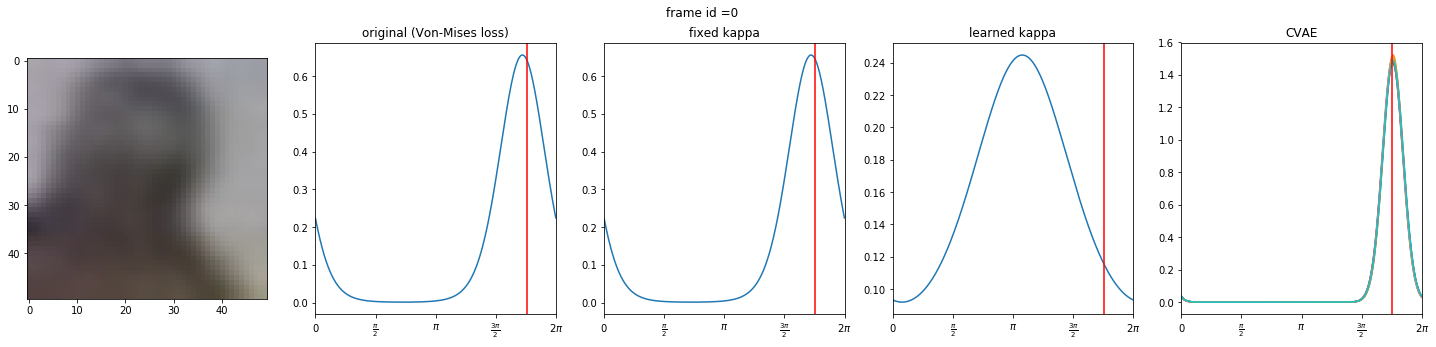

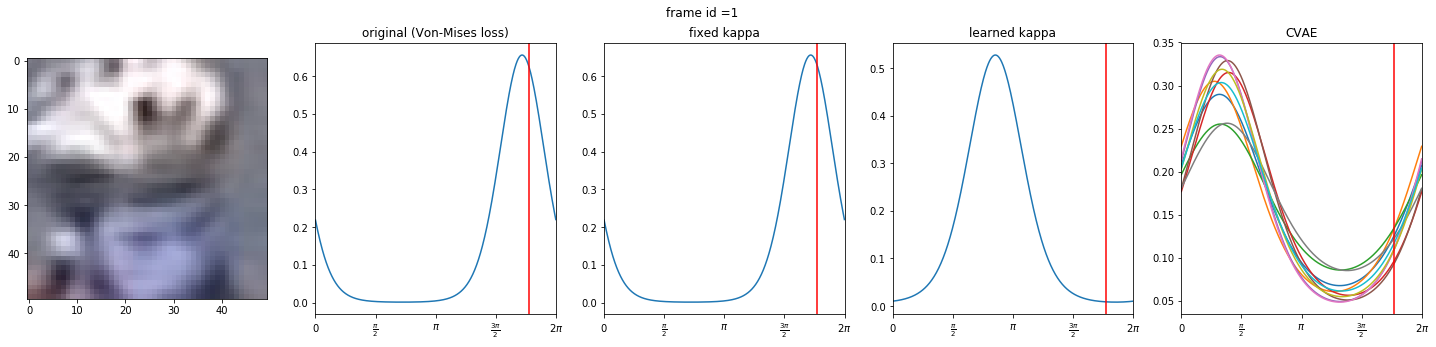

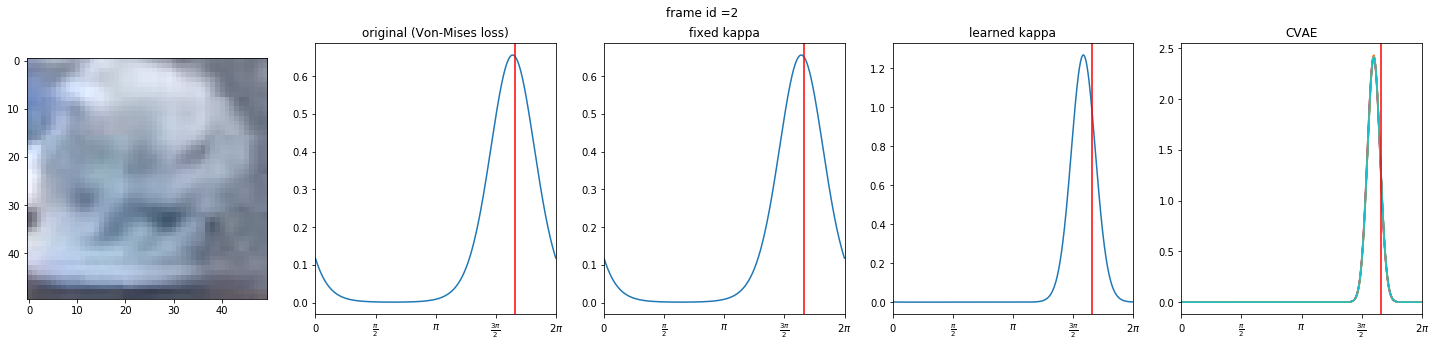

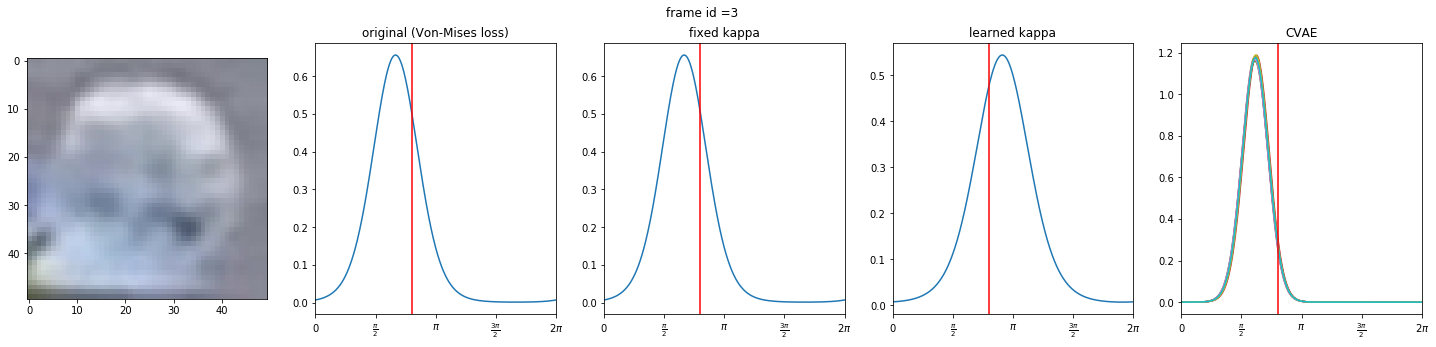

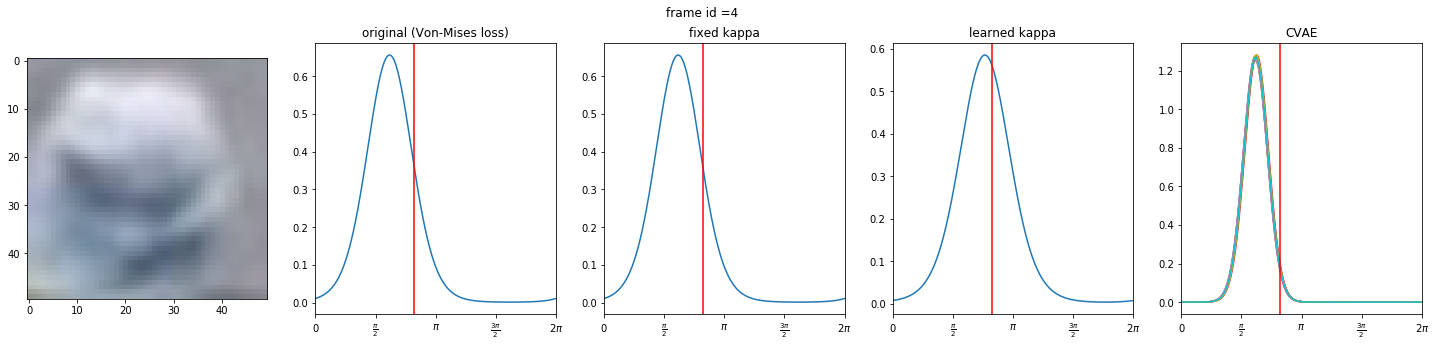

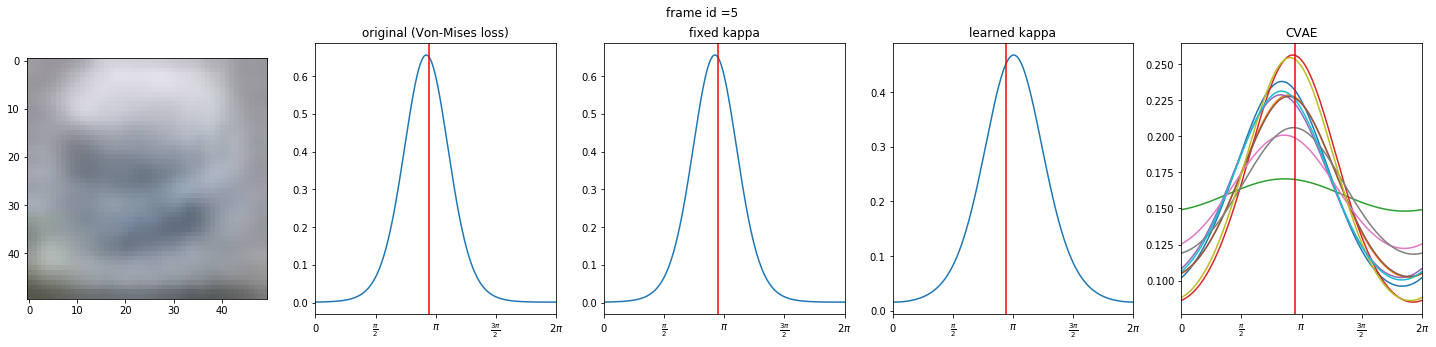

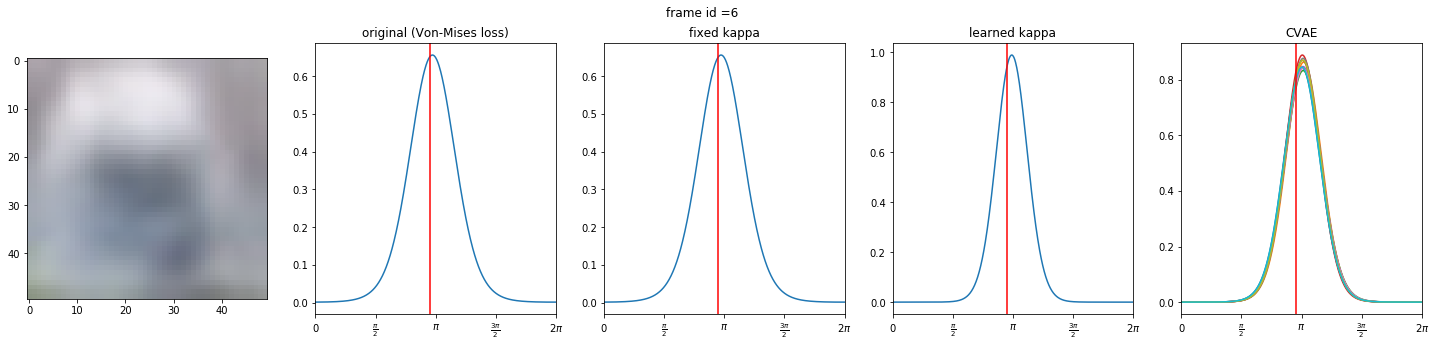

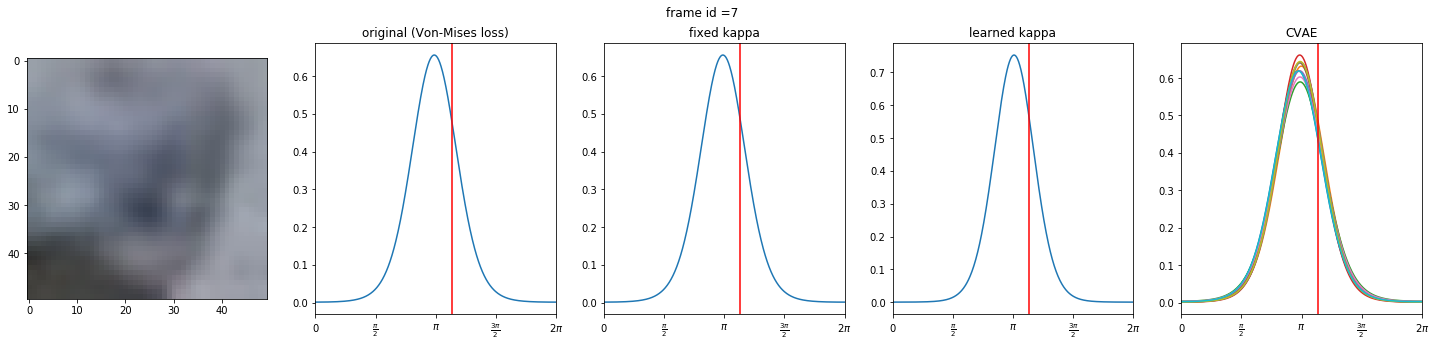

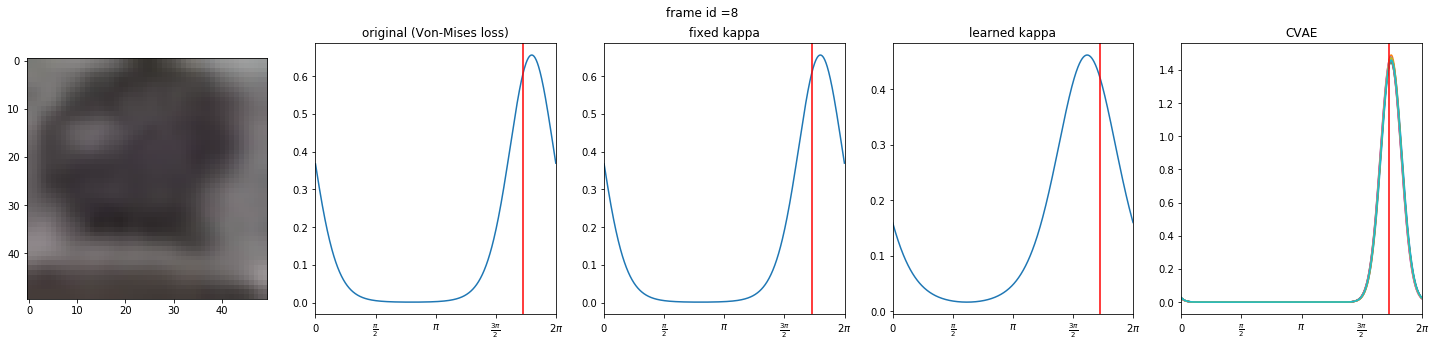

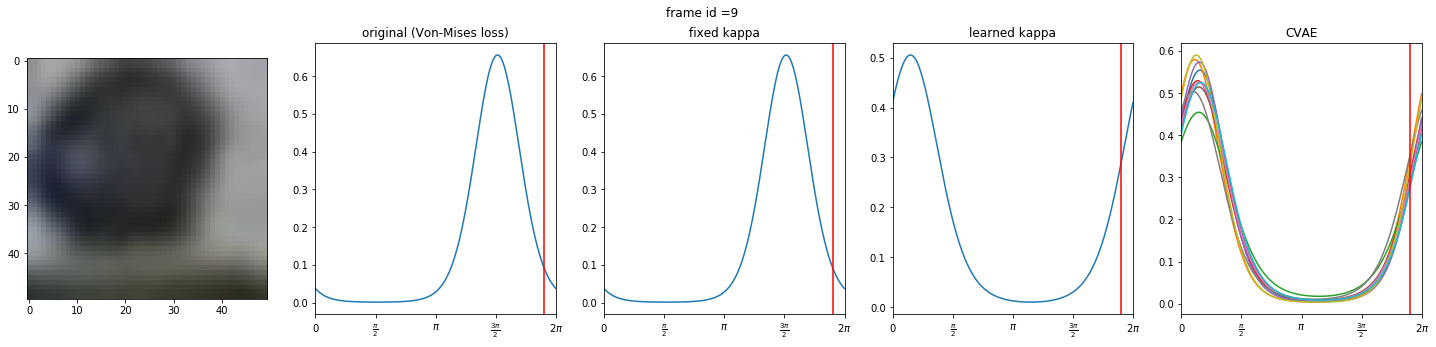

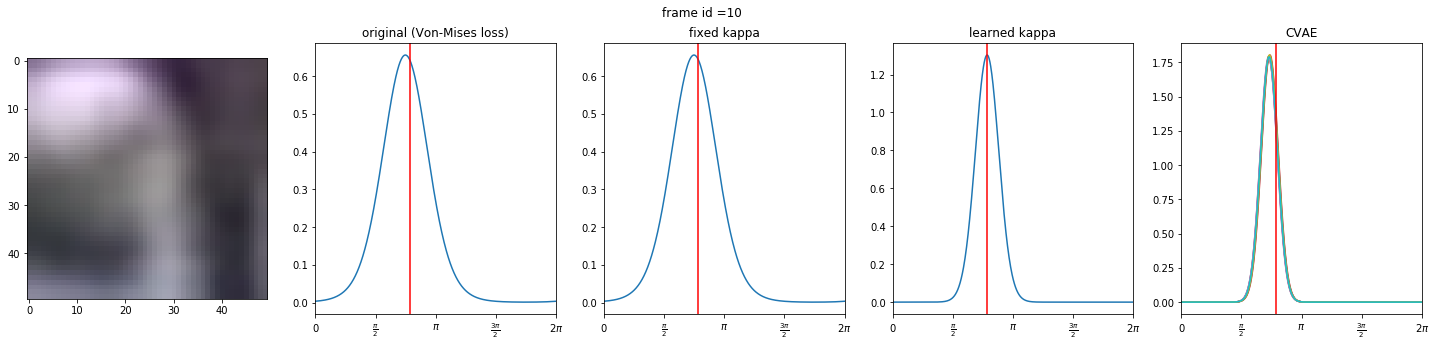

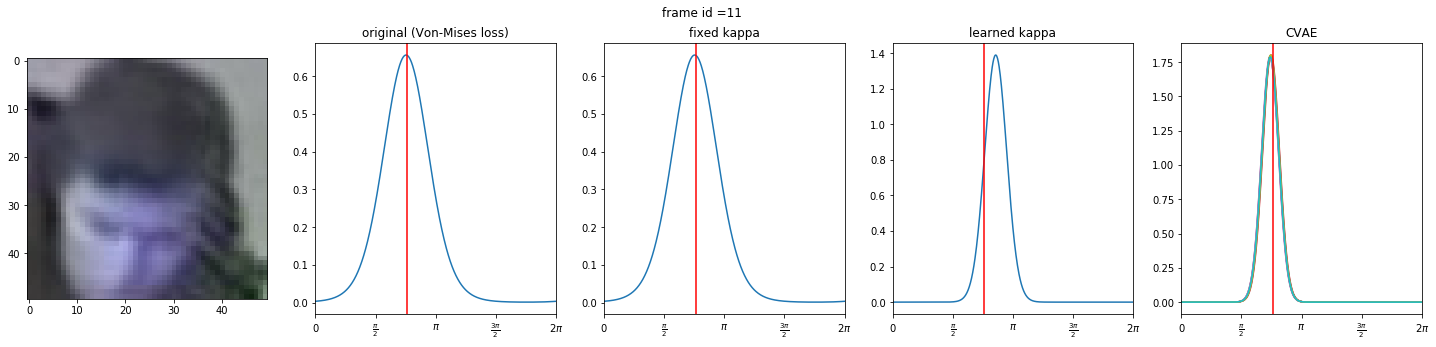

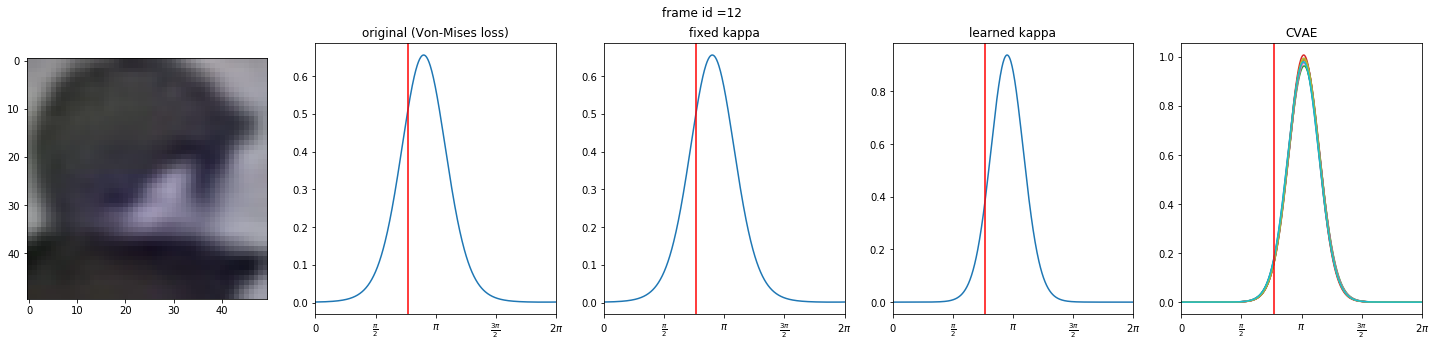

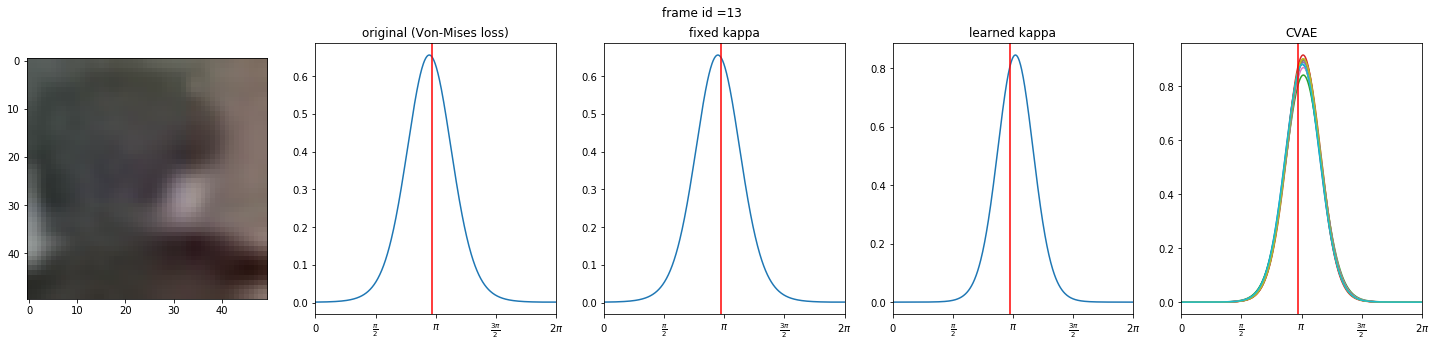

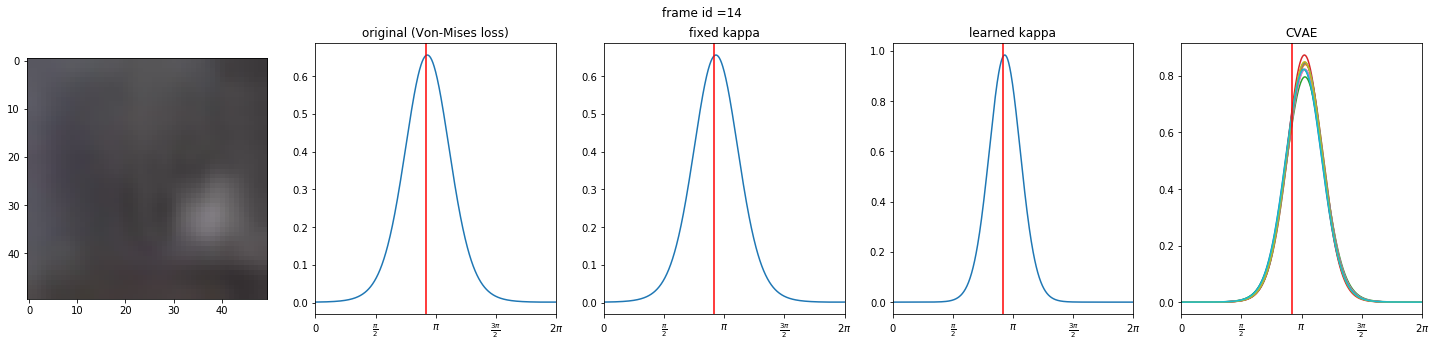

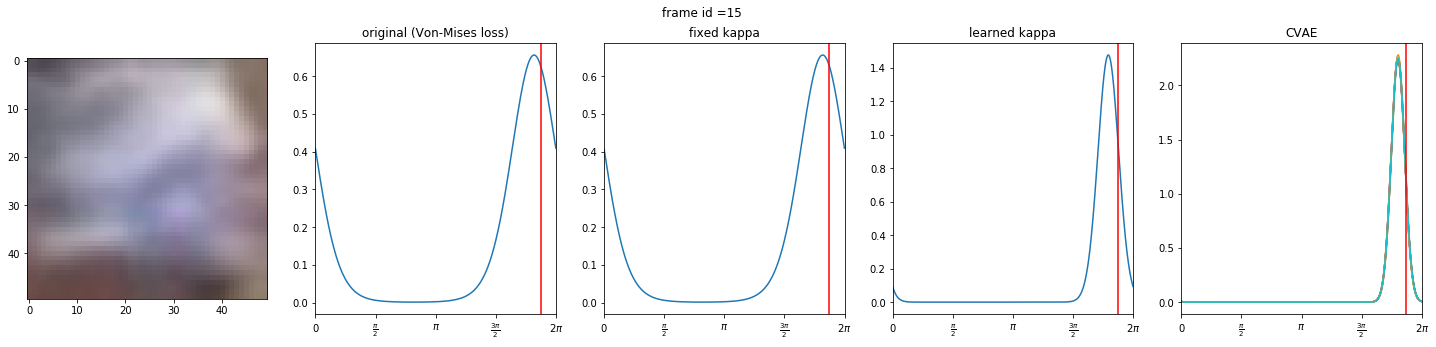

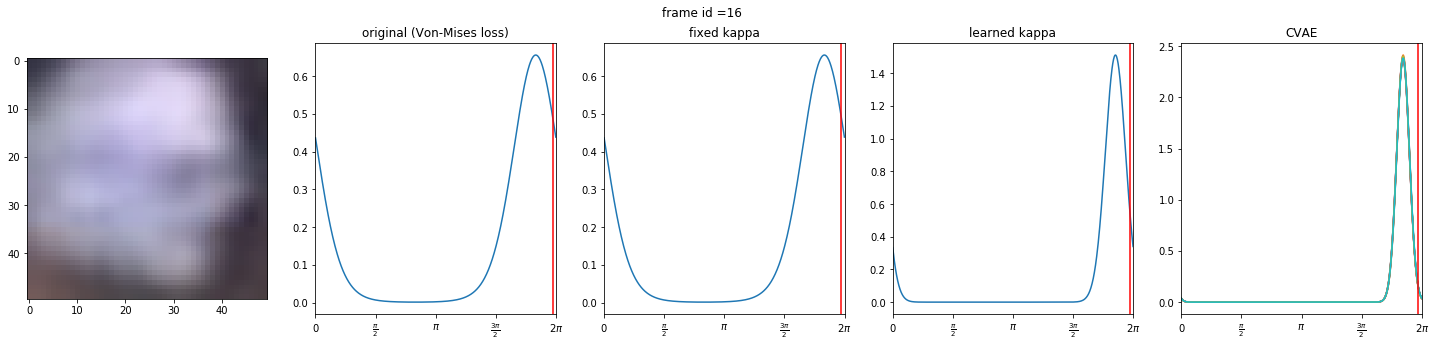

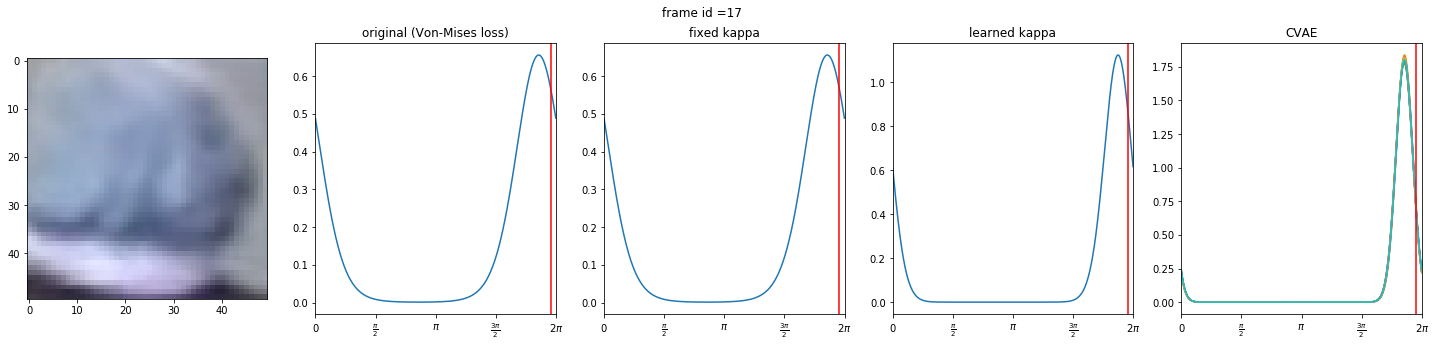

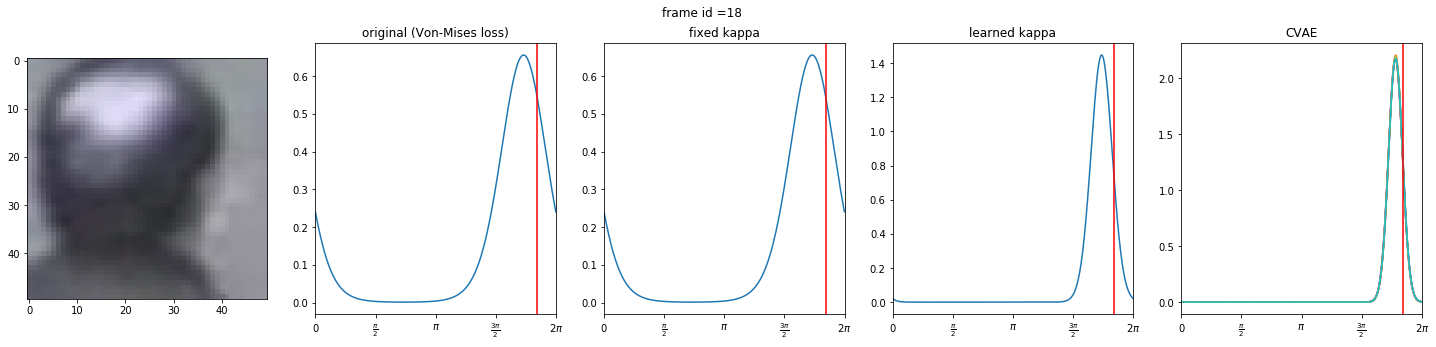

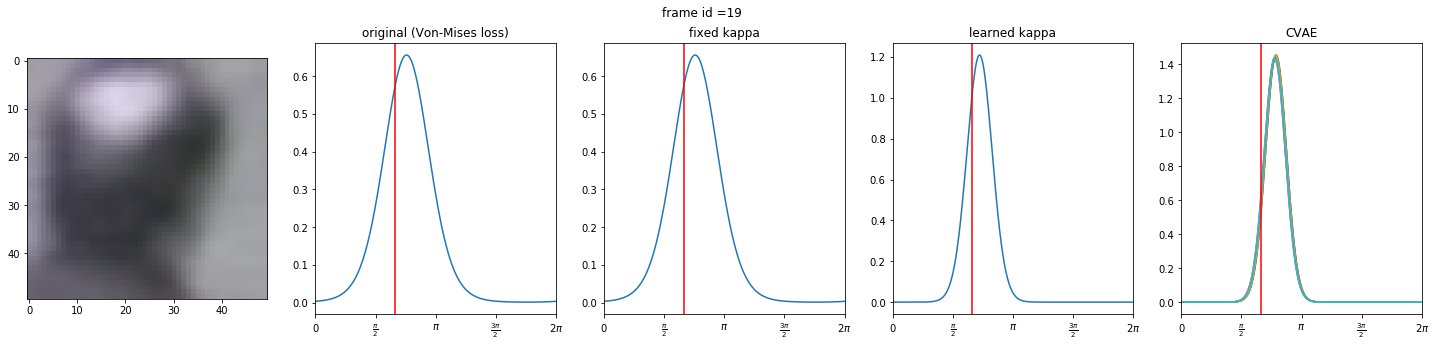

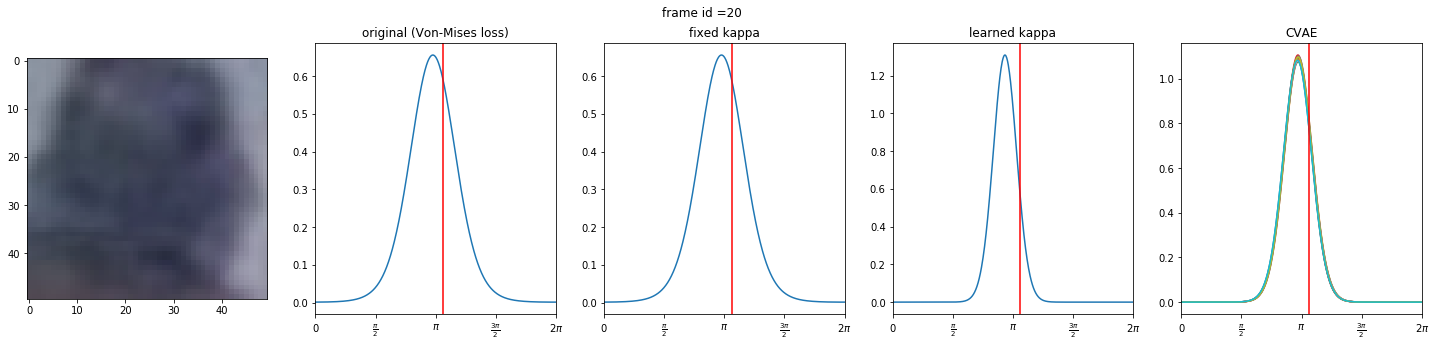

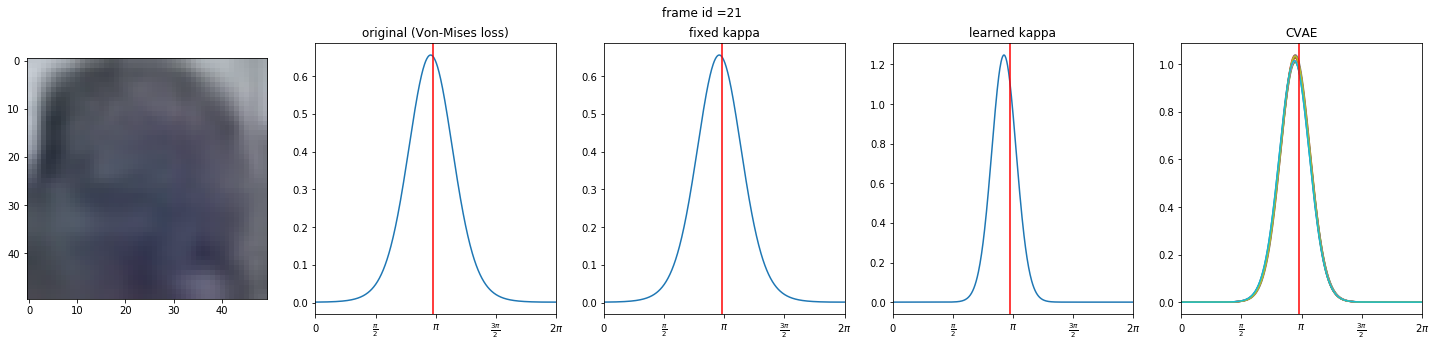

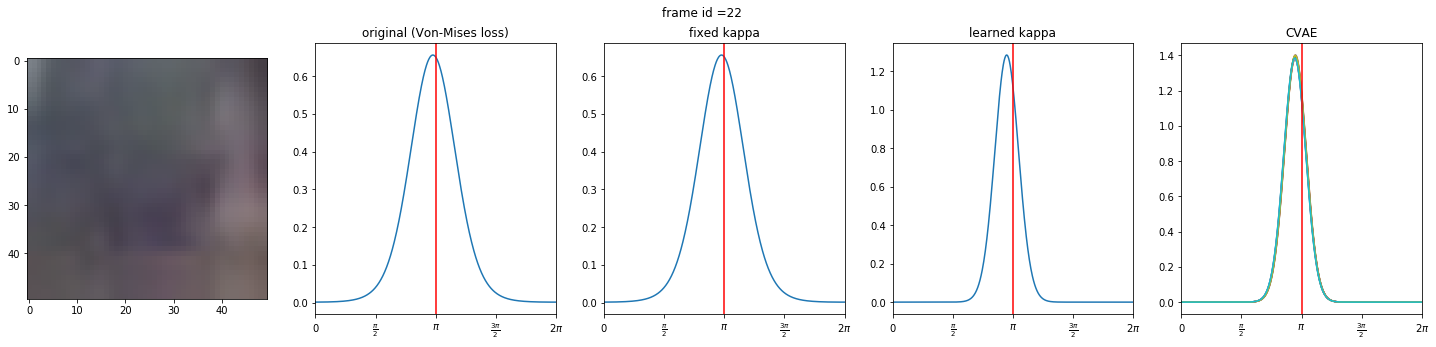

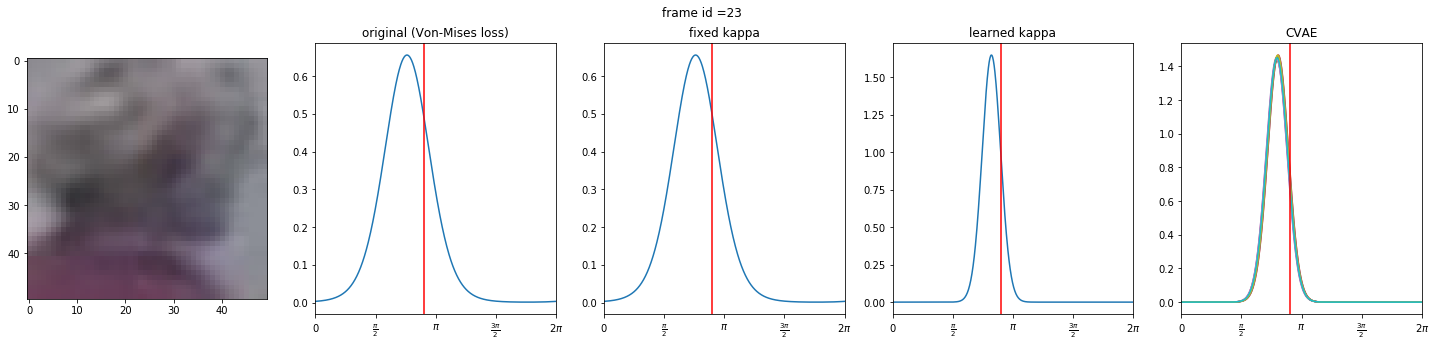

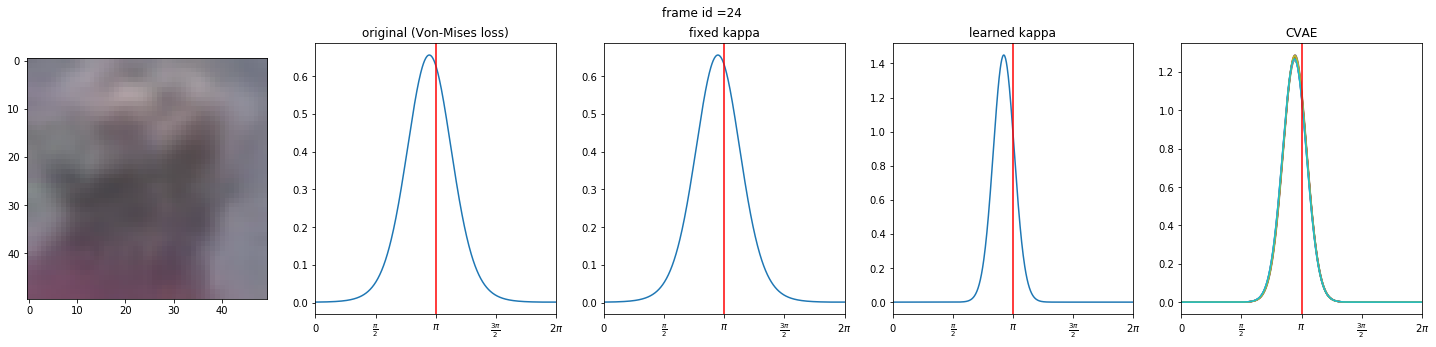

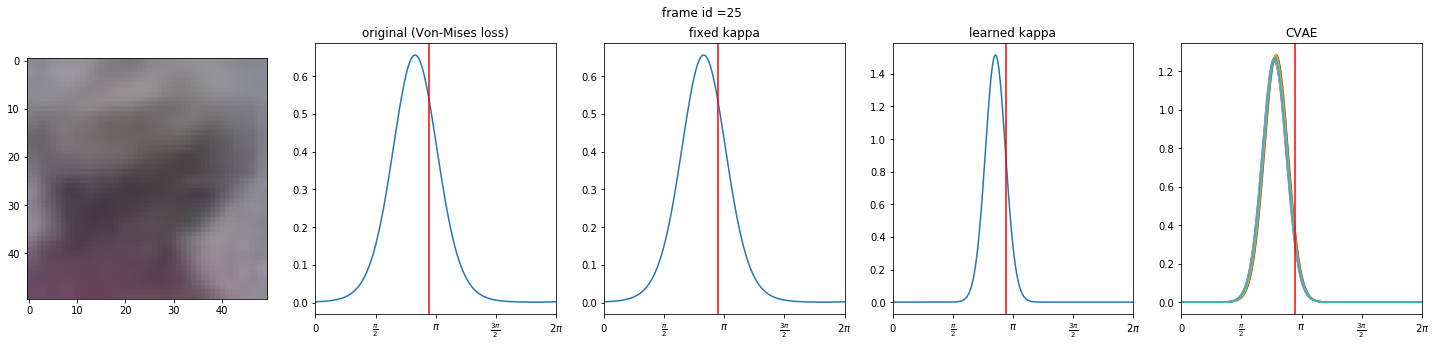

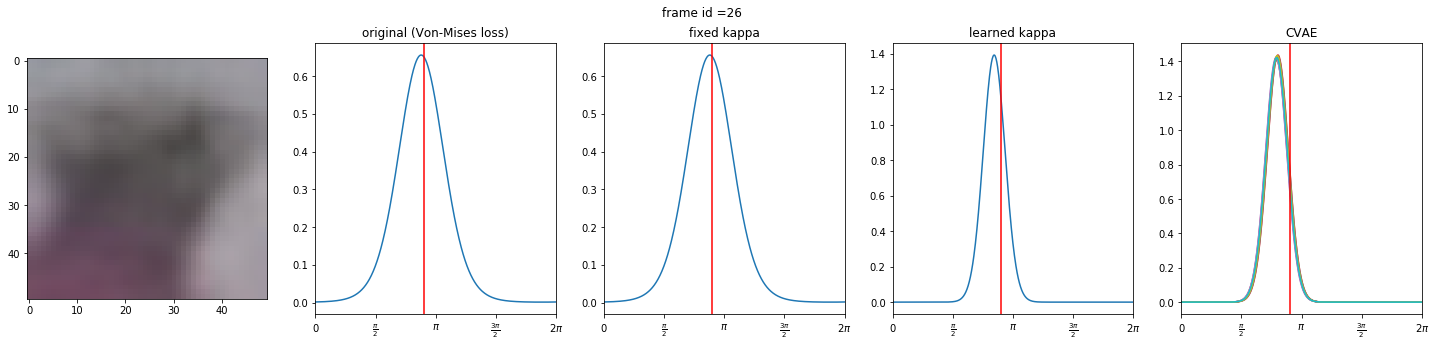

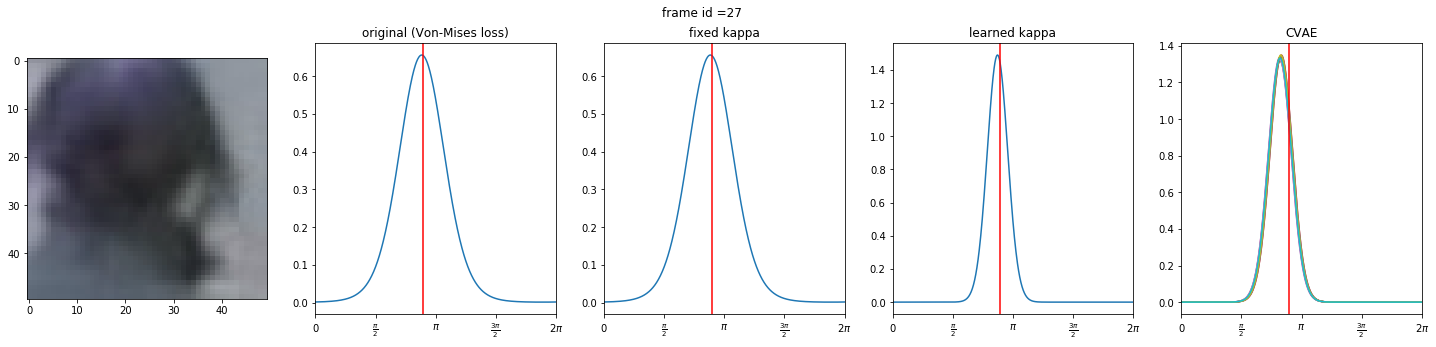

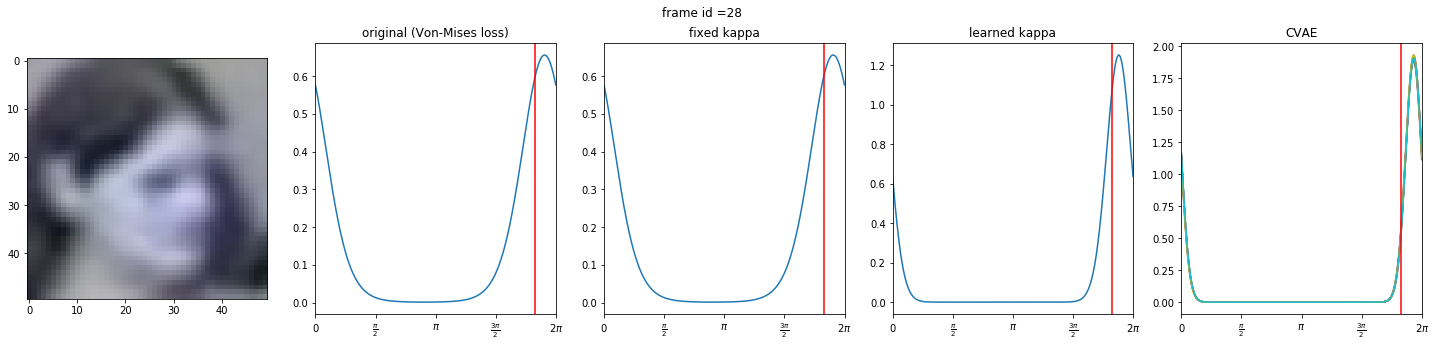

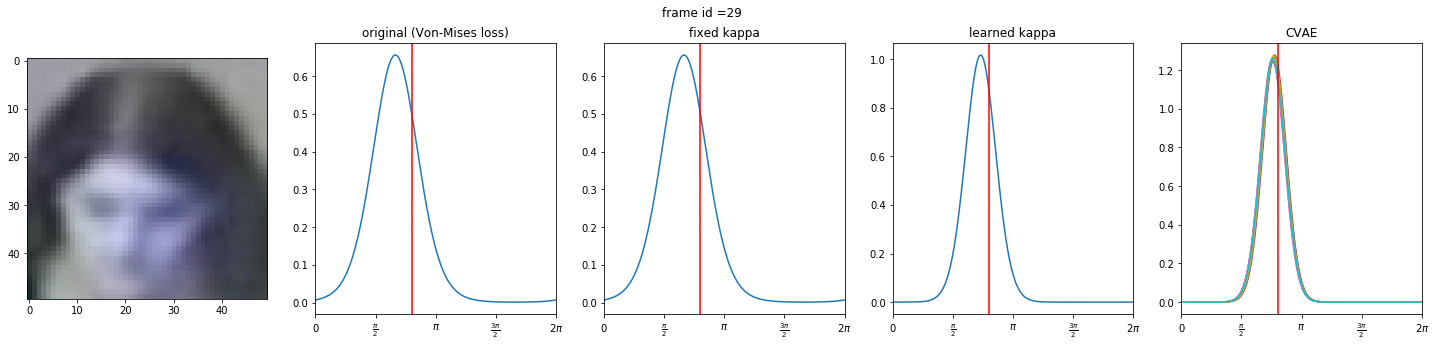

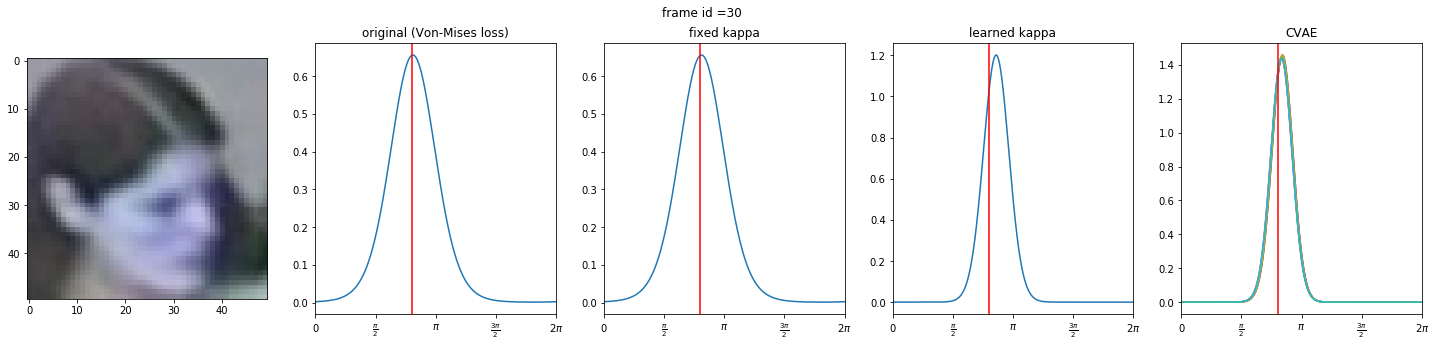

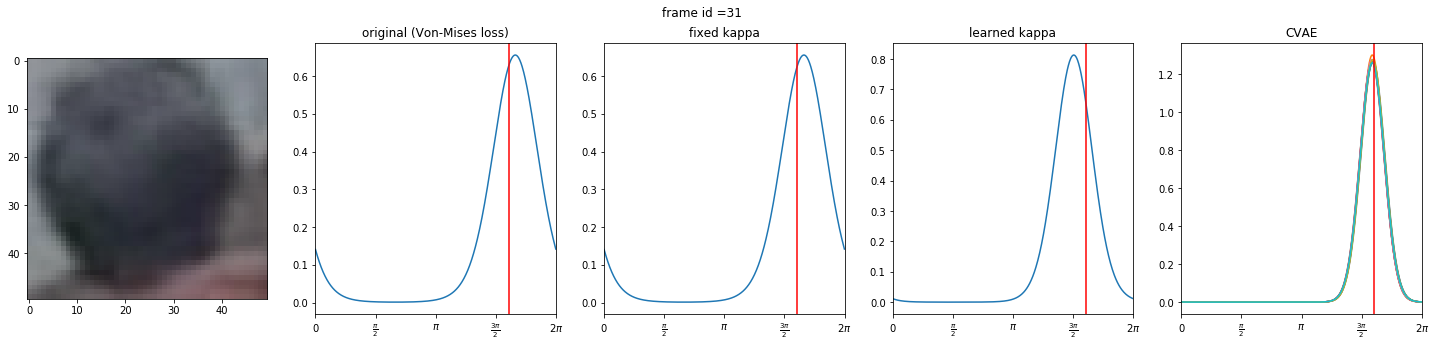

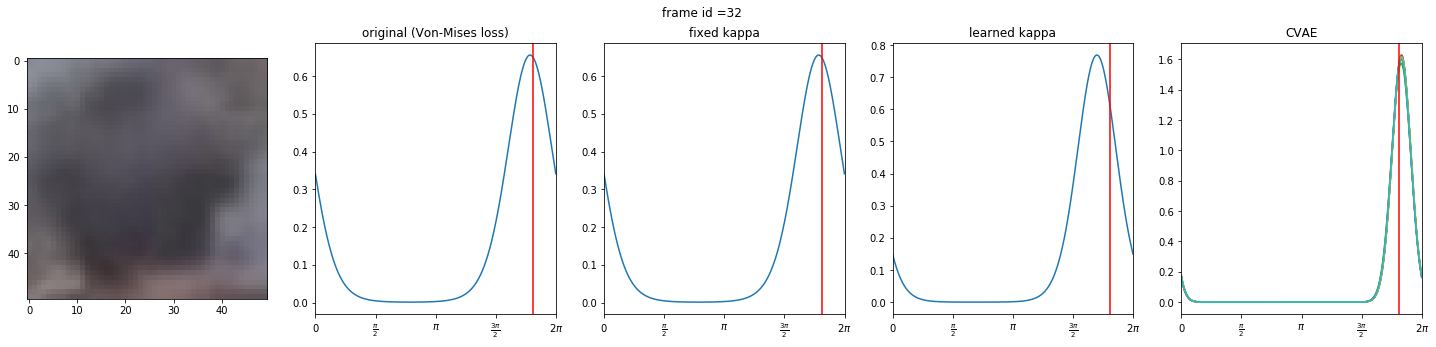

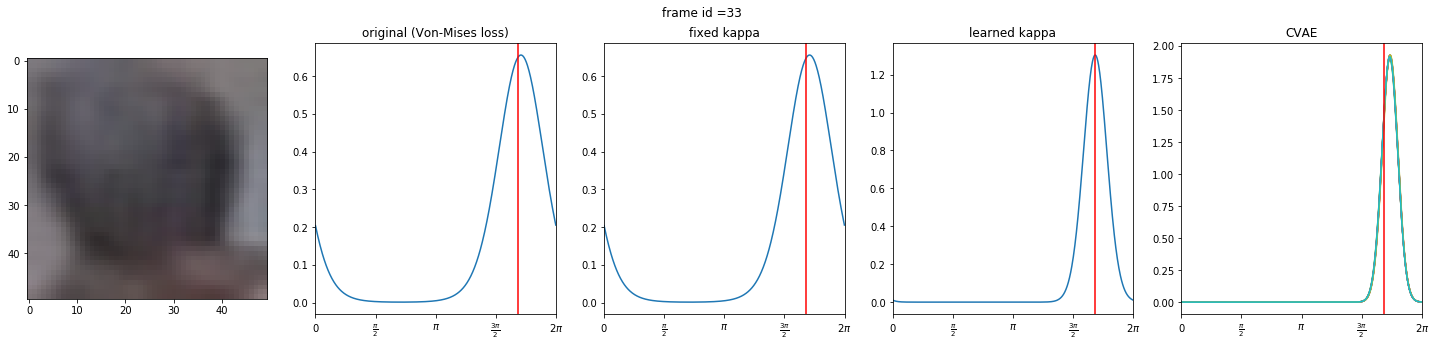

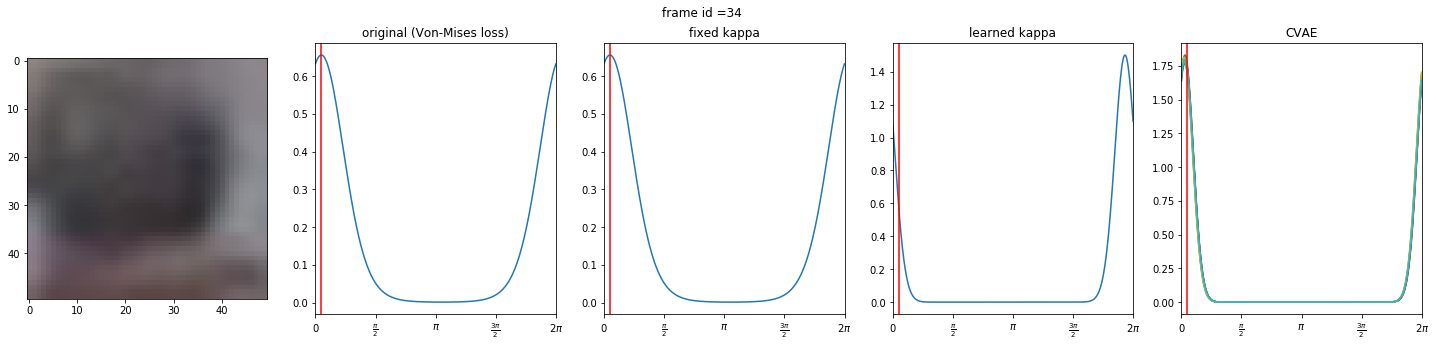

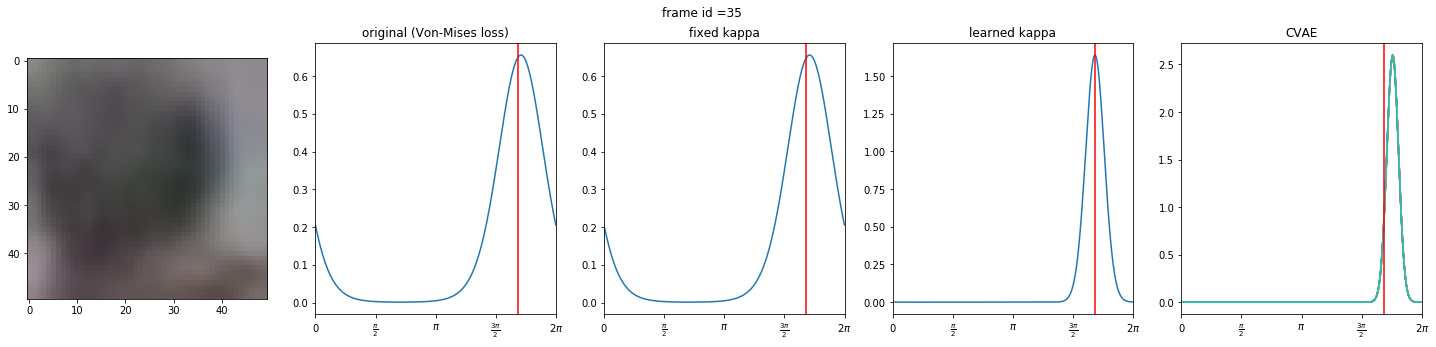

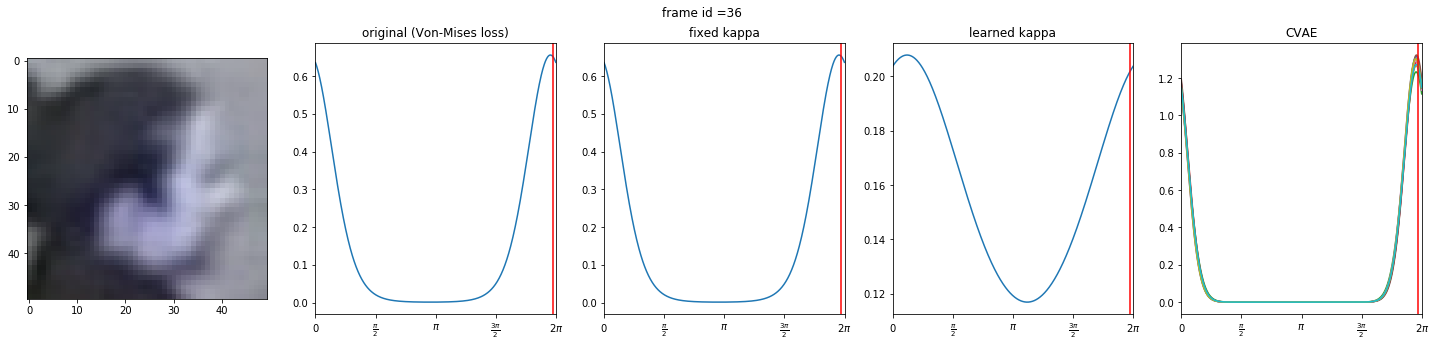

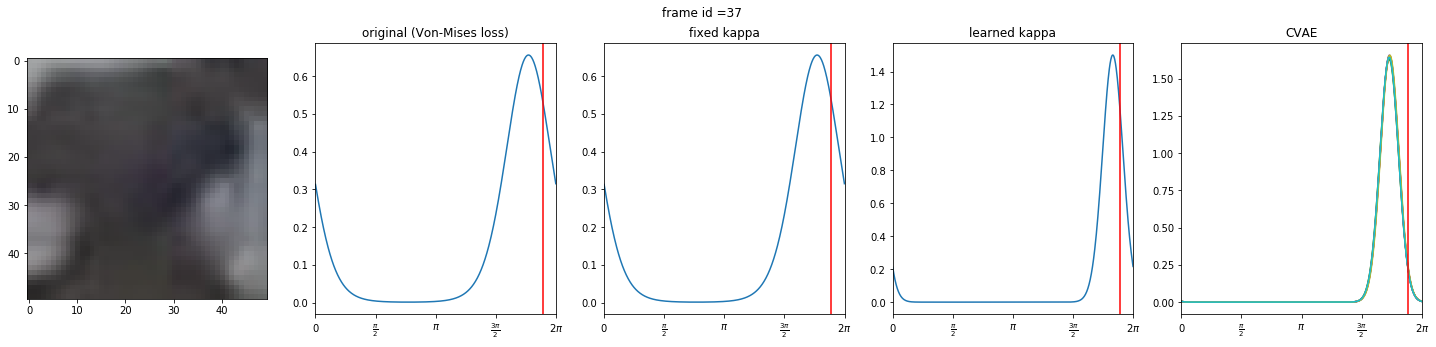

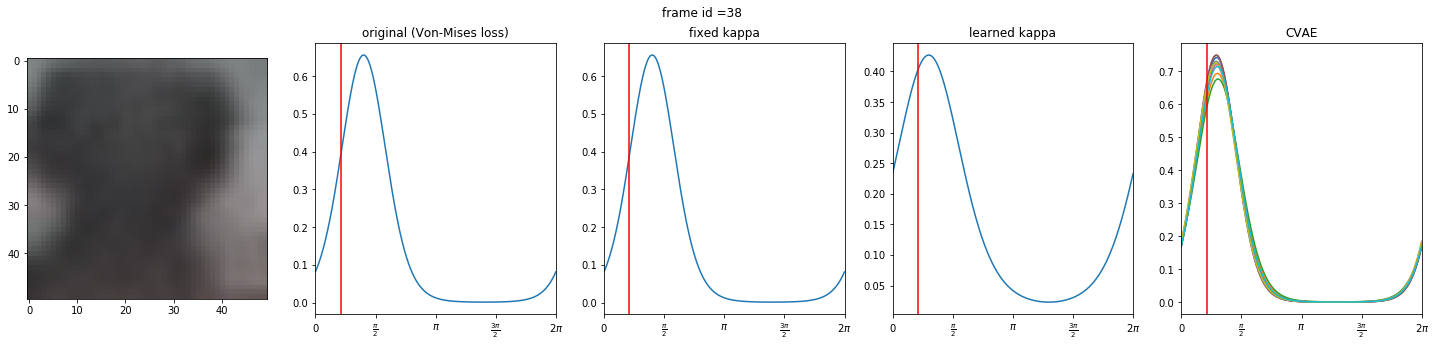

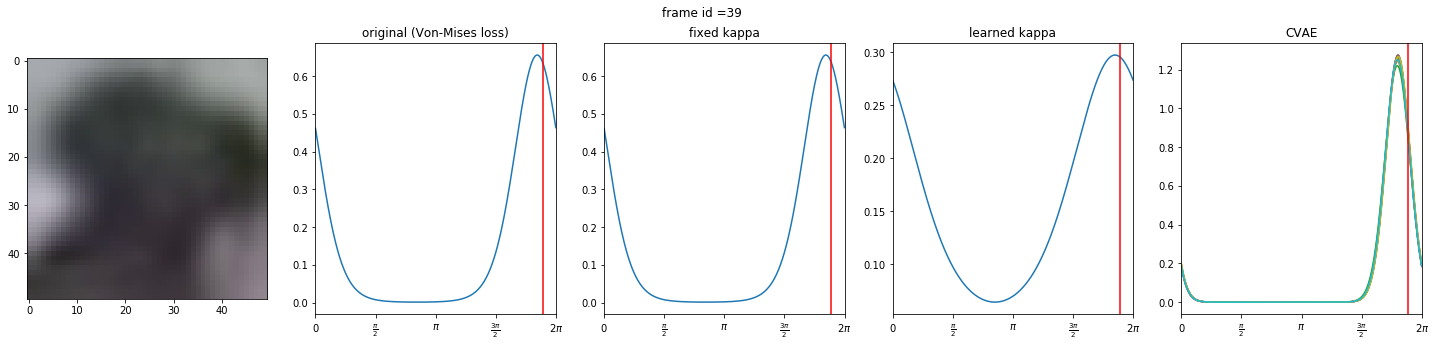

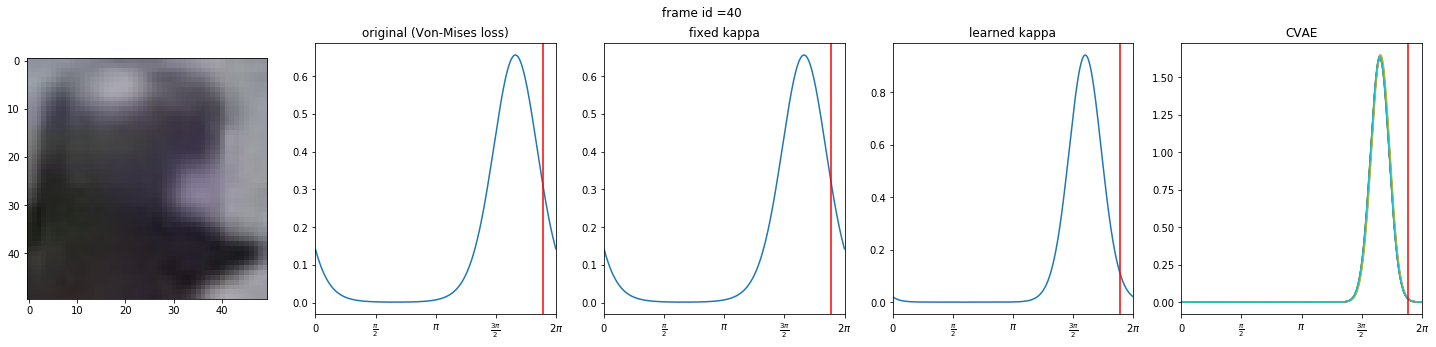

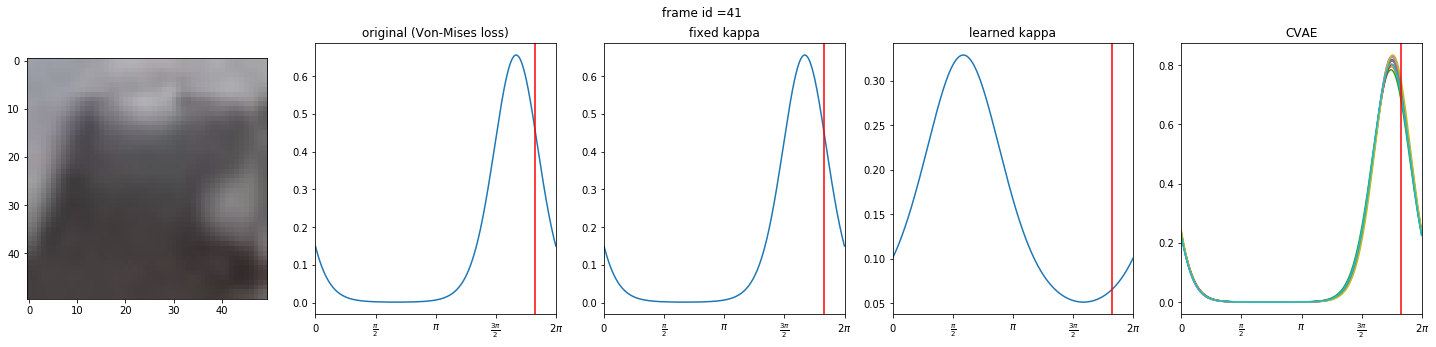

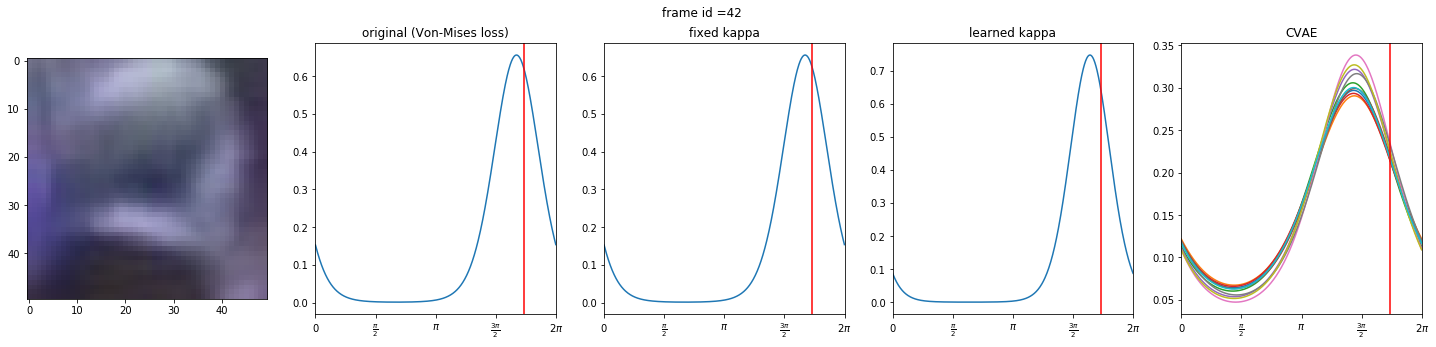

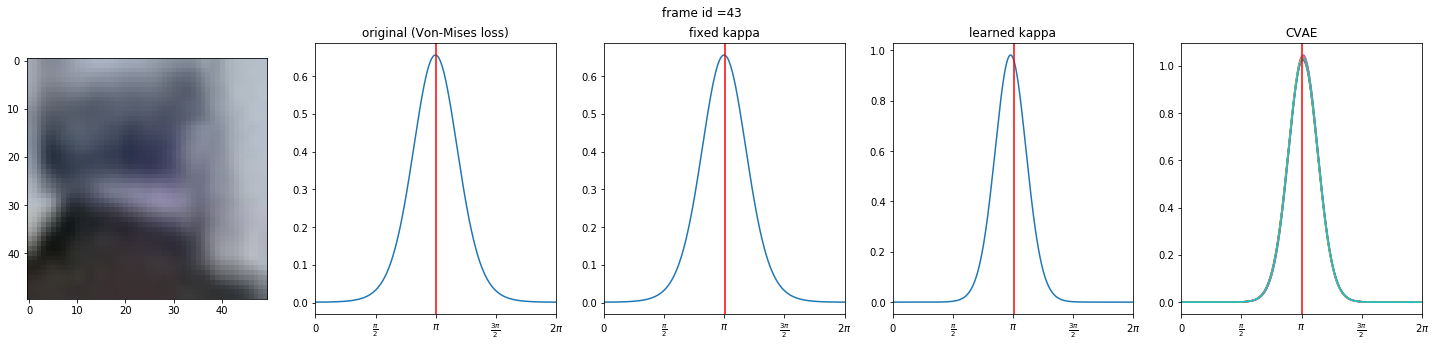

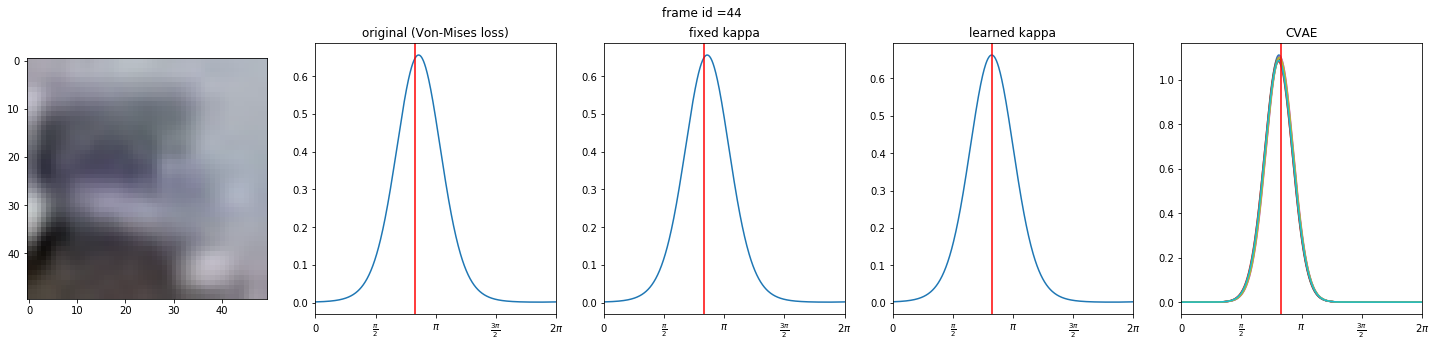

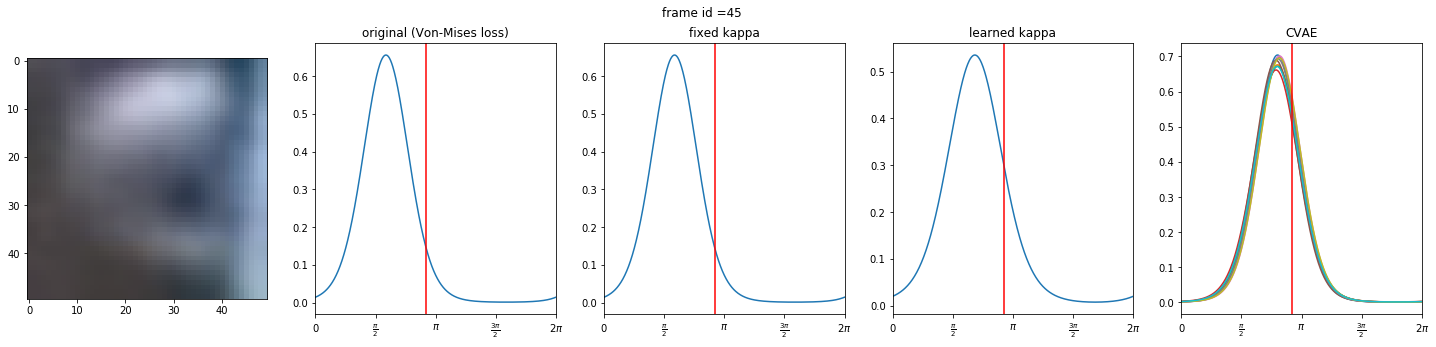

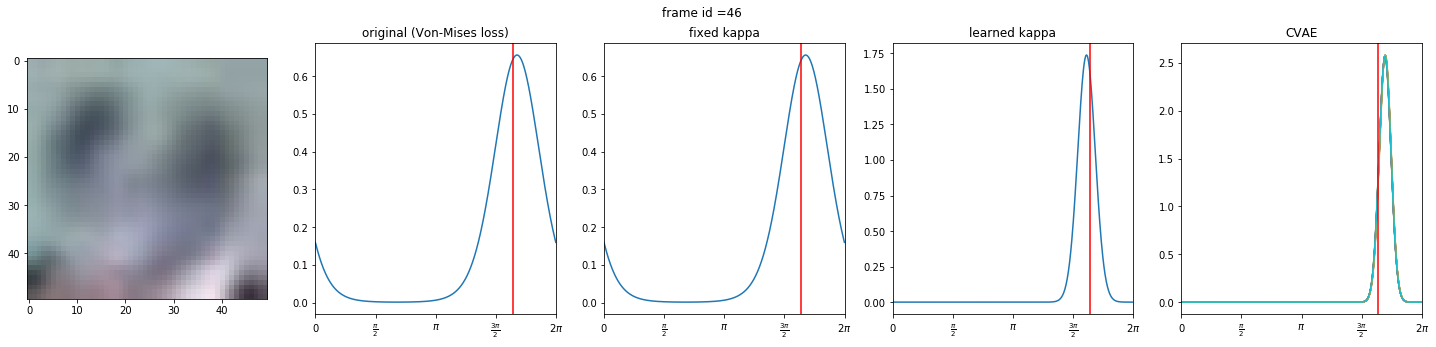

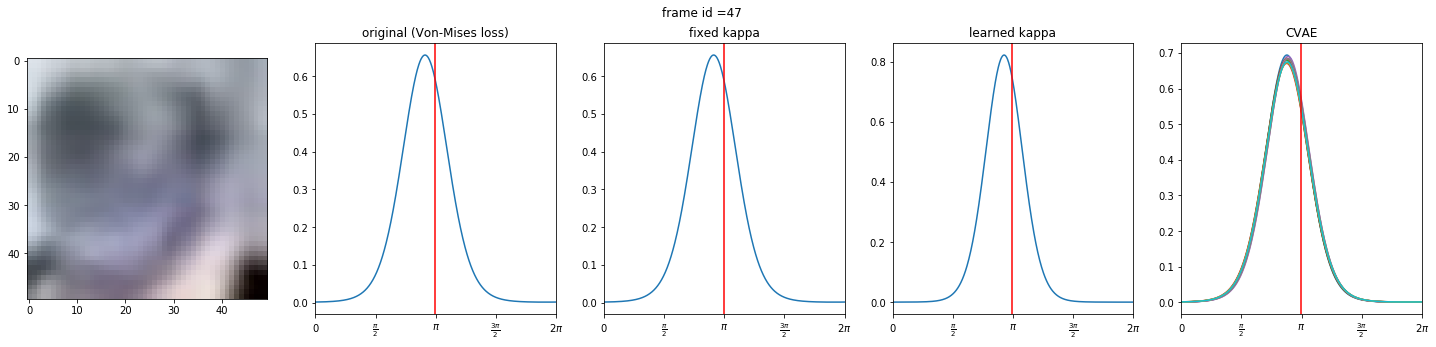

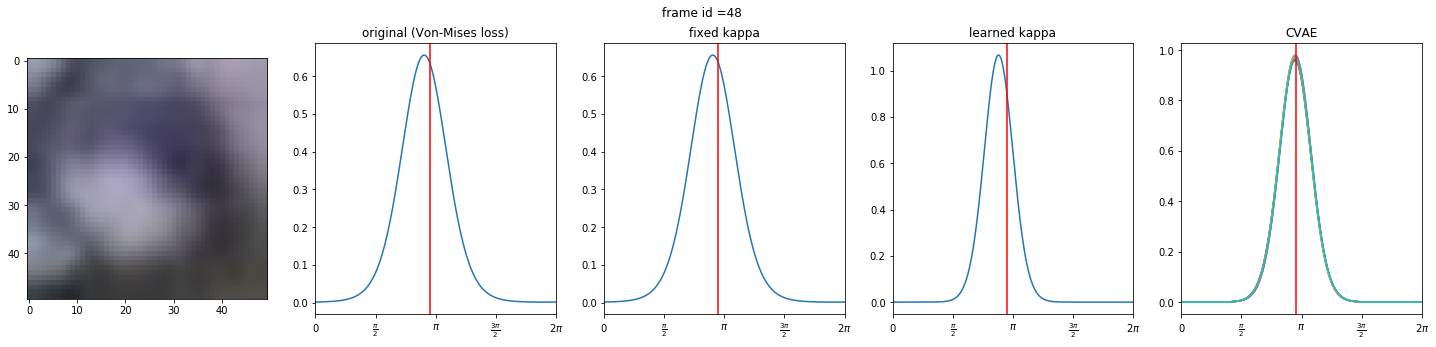

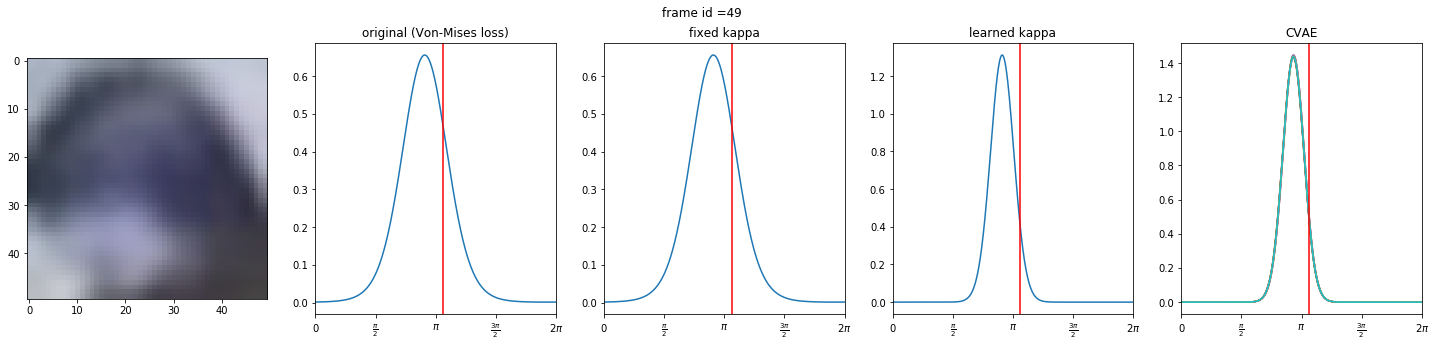

In [48]:
import time 

for fid in range(0, 50):
    plot_vm_dists(fid)